This notebook is for creating the base ML model.

In [1]:
model_name = "static_features" + "_model_files"

In [2]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [3]:
module_path = os.path.abspath(os.path.join('../..', 'utils'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

from ml_tools import add_weekends_holidays

d:\CS\summer_project\comp47360-group8\ml_pipeline\utils


In [4]:
df = pd.read_parquet('../../data_evaluation/taxi_trip_data/all_tlc_data_cleaned.parquet')
df.rename({'passenger_count':'busyness', 'datetime':'timestamp'},axis=1, inplace=True)
df.sort_values(by=['timestamp'])
print(df.columns)

Index(['timestamp', 'location', 'busyness'], dtype='object')


In [5]:
df.shape

(7319643, 3)

In [6]:
df.head()

,timestamp,location,busyness
0,2021-01-01,3,132
1,2021-01-01,4,234
2,2021-01-01,5,19
3,2021-01-01,6,37
4,2021-01-01,7,493


In [7]:
static_features_df = pd.read_csv("../../data_evaluation/taxi_trip_data/taxi_zone_lookup.csv")
static_features_df.rename({'LocationID': 'location'}, axis=1, inplace=True)
static_features_df

,location,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NaN,NaN


In [8]:
static_features_df.dtypes

location         int64
Borough         object
Zone            object
service_zone    object
dtype: object

In [9]:
data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="location",
    timestamp_column="timestamp",
    static_features_df = static_features_df
)
print(data.head())

                    busyness
item_id timestamp           
3       2021-01-01       132
4       2021-01-01       234
5       2021-01-01        19
6       2021-01-01        37
7       2021-01-01       493


In [10]:
data.head()

,,busyness
item_id,timestamp,
3,2021-01-01,132
4,2021-01-01,234
5,2021-01-01,19
6,2021-01-01,37
7,2021-01-01,493


In [11]:
prediction_length = 3 * 30 * 24 # 3 months prediction window
train_data, test_data = data.train_test_split(prediction_length)

In [12]:
# setting the frequency to h since the data is grouped/collected hourly,
# # added relative path 

predictor = TimeSeriesPredictor(
    freq='h',
    target="busyness",
    eval_metric="MASE",
    prediction_length=prediction_length,
    path=model_name
)
print('we made the predictor')

we made the predictor


In [13]:
predictions = predictor.fit(train_data,
                                presets="medium_quality"
                                )


Beginning AutoGluon training...
AutoGluon will save models to 'static_features_model_files'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.19
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       7.84 GB / 15.90 GB (49.3%)
Disk Space Avail:   2131.18 GB / 2794.50 GB (76.3%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2160,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'busyness',
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'h'.
Provided train_data has 6826363 rows (NaN fraction=1.0%), 2

In [14]:
print(predictor.leaderboard())

              model  score_val  pred_time_val  fit_time_marginal  fit_order
0  WeightedEnsemble  -1.198524     738.236027          89.721291          7
1     SeasonalNaive  -1.339581       1.076322           5.150827          2
2     DirectTabular  -1.680540      74.658951         236.257276          4
3  RecursiveTabular  -2.143076     606.986434         368.489088          3
4             Theta  -2.269781      51.754826           5.391212          6
5             Naive  -2.354159       3.759494           5.216575          1
6               ETS  -9.005625     201.278598           5.495665          5


In [15]:
predictions = predictor.predict(train_data)
print(predictions)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


                                   mean         0.1         0.2         0.3  \
item_id timestamp                                                             
3       2024-01-01 23:00:00  140.630457  108.812292  119.569041  127.337856   
        2024-01-02 00:00:00   91.966109   56.957577   68.956328   77.590426   
        2024-01-02 01:00:00  113.024281   75.538500   88.378316   97.589743   
        2024-01-02 02:00:00  103.355968   64.260851   77.652704   87.379802   
        2024-01-02 03:00:00   75.387217   34.126943   48.248974   58.491320   
...                                 ...         ...         ...         ...   
110     2022-04-23 13:00:00    1.227205  -11.492775   -7.127513   -3.970798   
        2022-04-23 14:00:00    1.234154  -11.486841   -7.117274   -3.957609   
        2022-04-23 15:00:00    1.250274  -11.476821   -7.103198   -3.947716   
        2022-04-23 16:00:00    1.262850  -11.467837   -7.087073   -3.931873   
        2022-04-23 17:00:00    1.285776  -11.466777 

data with frequency 'None' has been resampled to frequency 'h'.


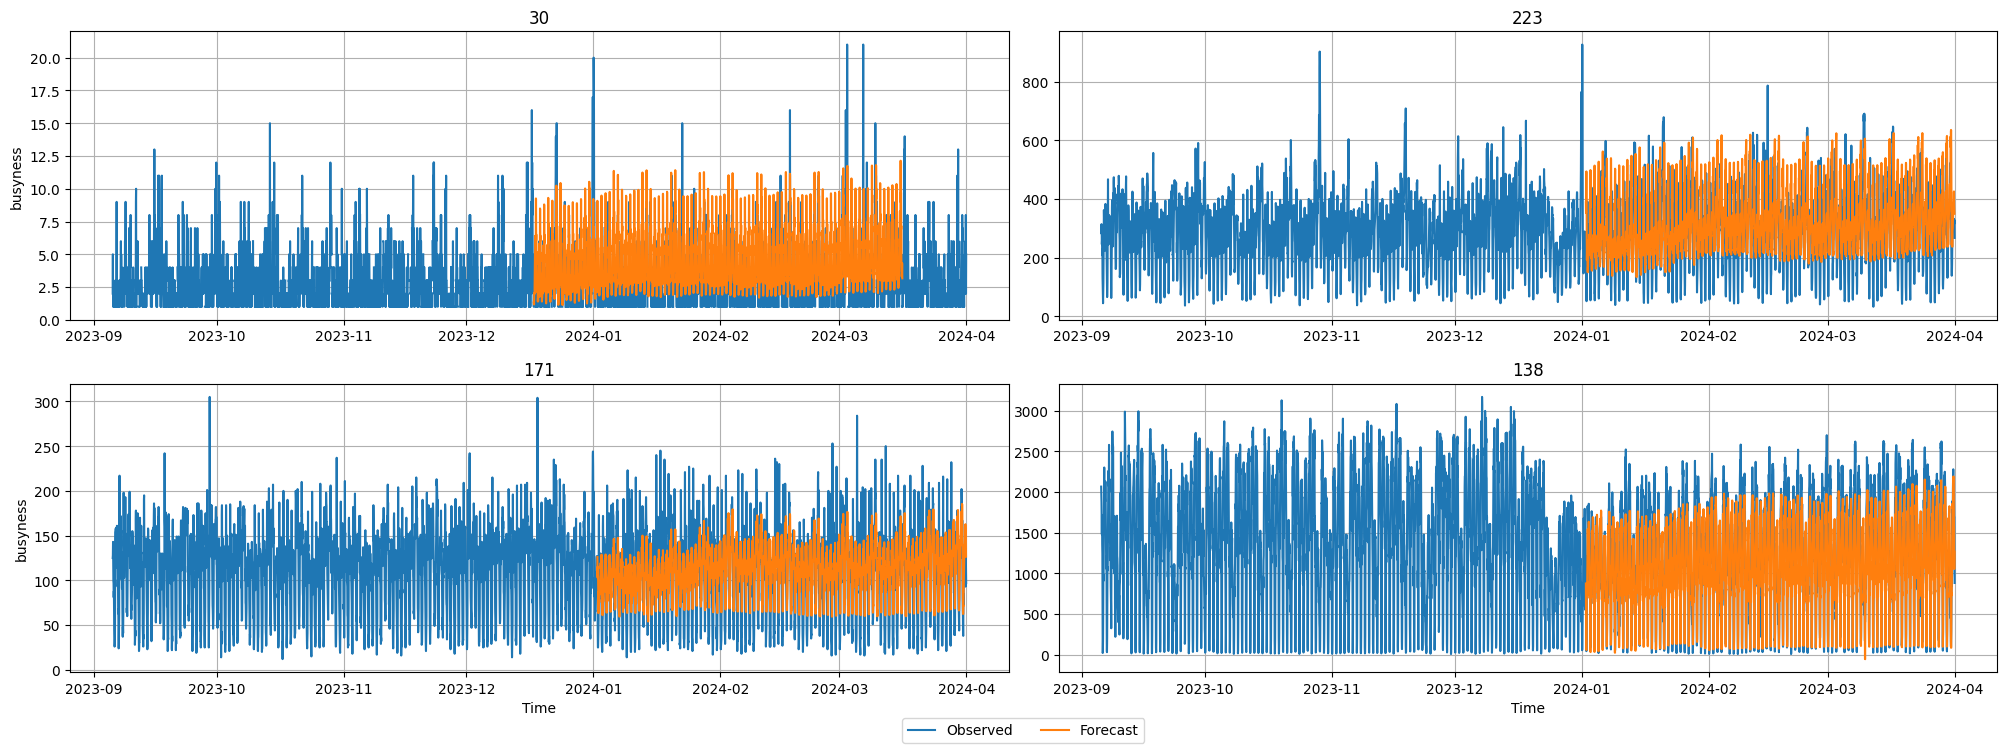

In [16]:
plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  max_num_item_ids=4)


data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.


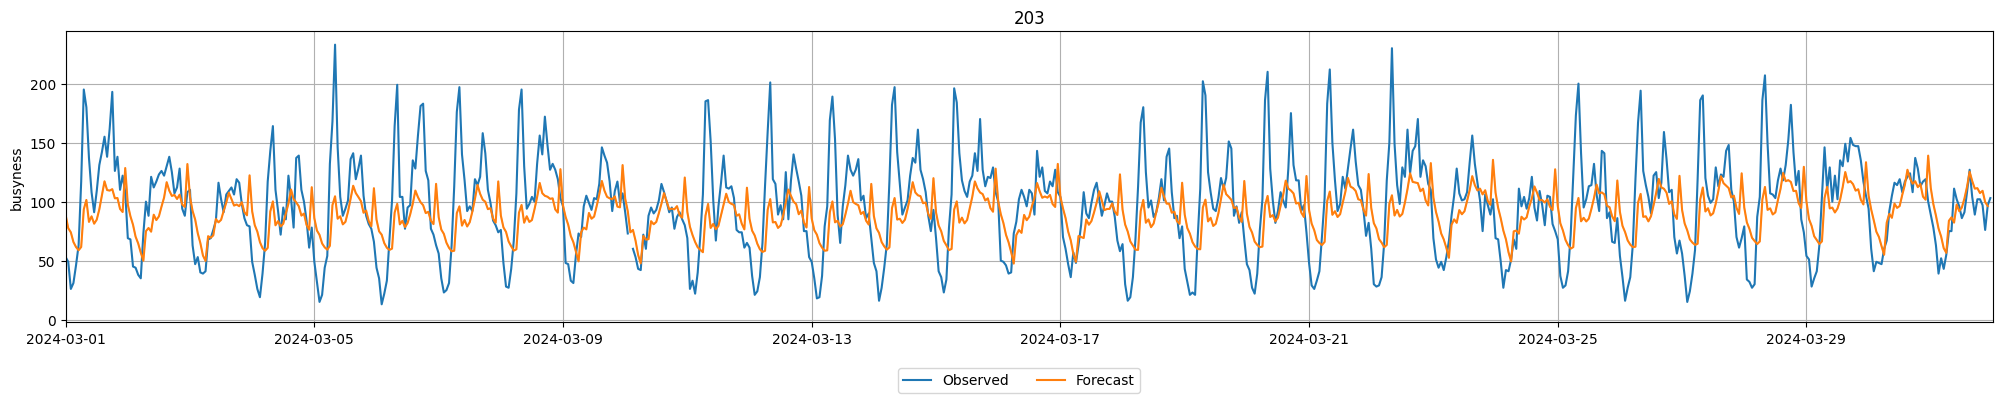

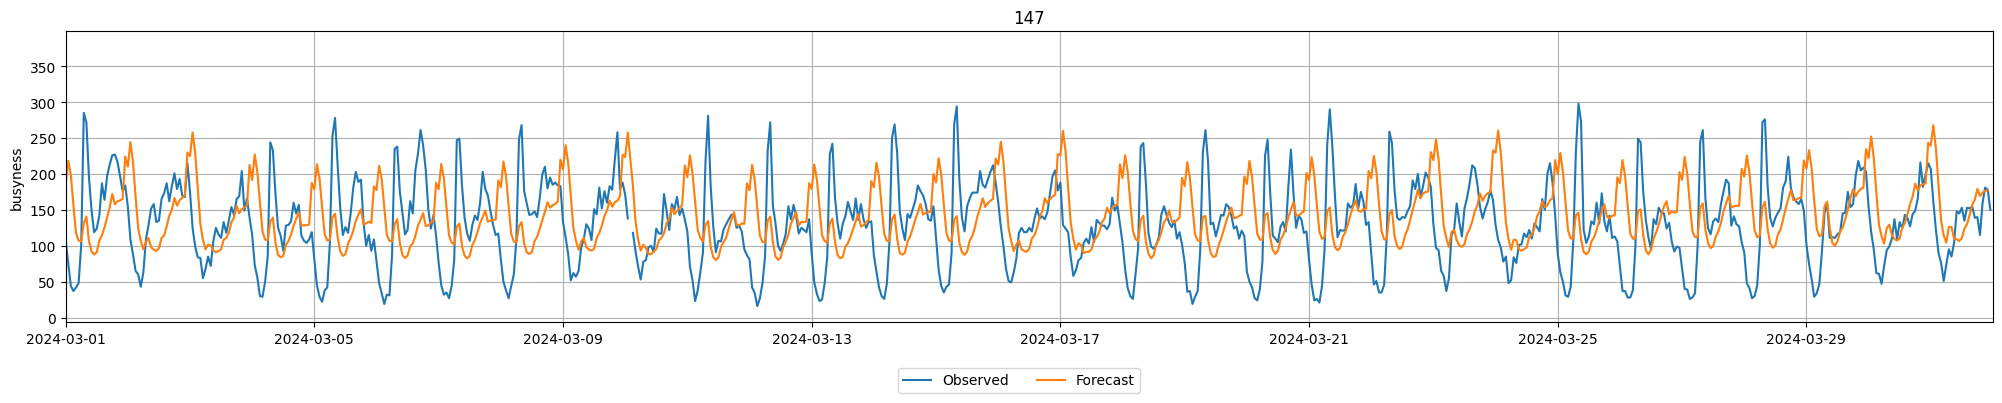

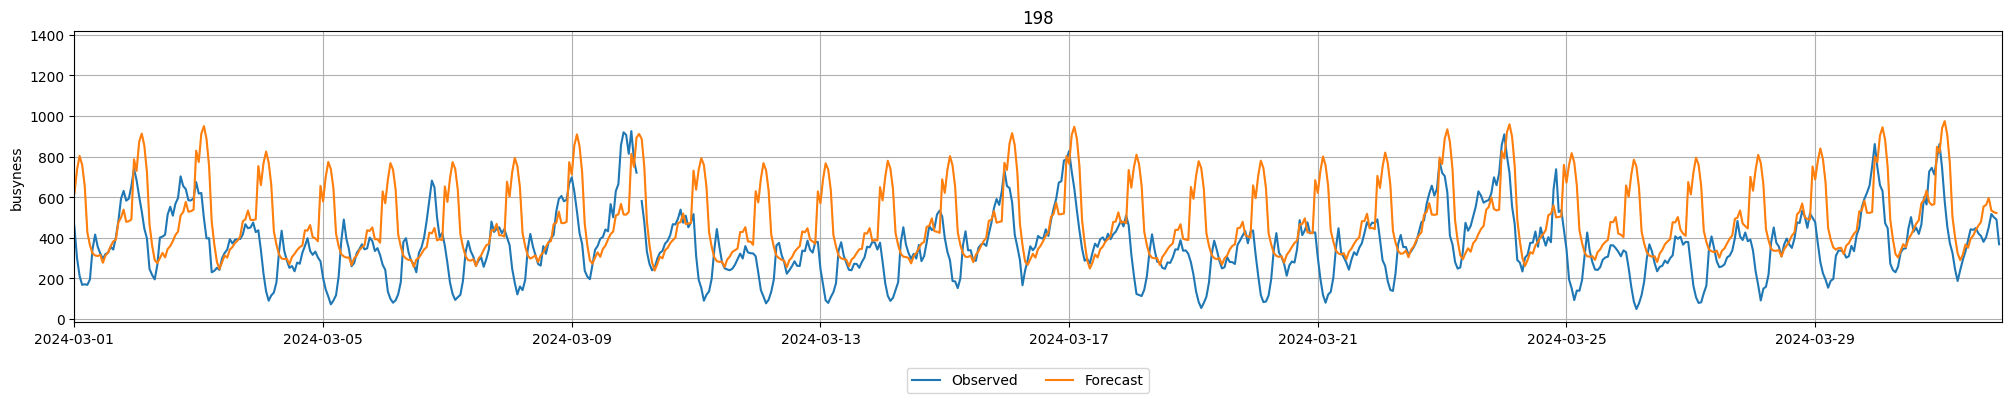

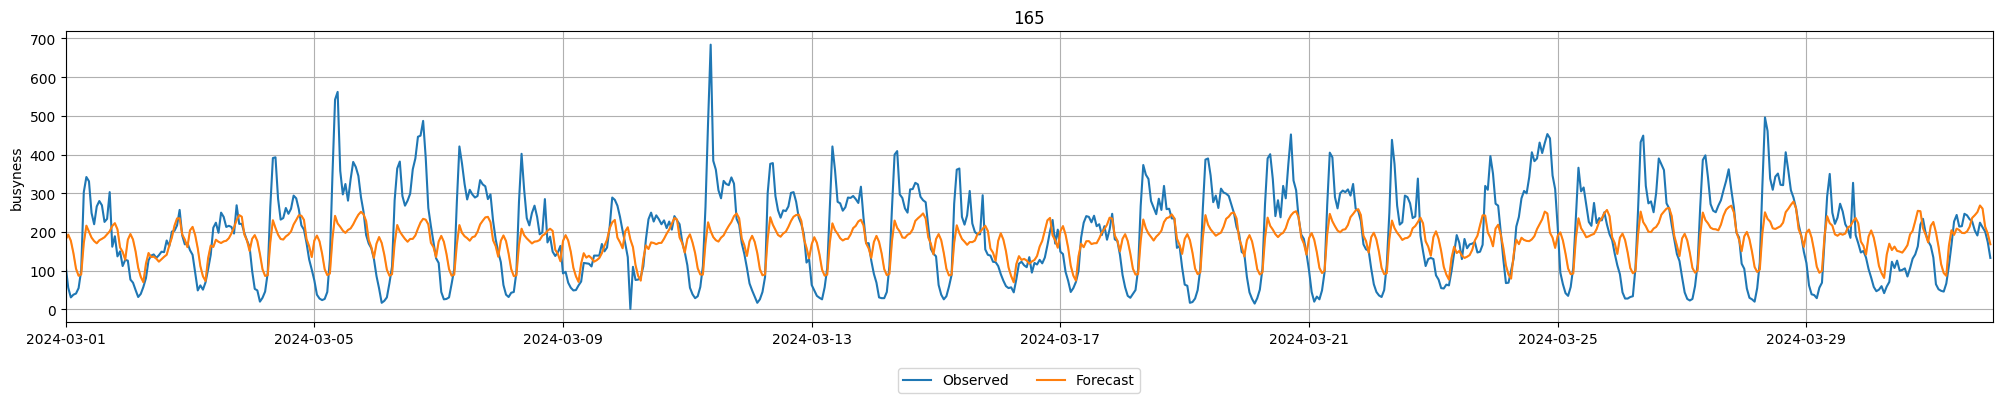

In [17]:
xmin = pd.Timestamp('2024-03-01 00:00:00')
xmax = pd.Timestamp('2024-03-31 23:59:59')
item_ids = [203, 147, 198, 165]
for id in item_ids:
    plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  item_ids=[id])
    ax = plot.gca()
    ax.set_xlim([xmin, xmax])
plt.show()

In [18]:
predictor.evaluate(test_data)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


{'MASE': -1.9546299495226067}